# Author : Nonbangkok
## Code for : https://www.kaggle.com/competitions/detect-ai-vs-human-generated-images/overview

### Preparation

In [1]:
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras import layers, Model, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import seaborn as sns
import pandas as pd
import numpy as np
import os

### Load Data

In [2]:
df = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/train.csv")
df

,Unnamed: 0,file_name,label
0,0,train_data/a6dcb93f596a43249135678dfcfc17ea.jpg,1
1,1,train_data/041be3153810433ab146bc97d5af505c.jpg,0
2,2,train_data/615df26ce9494e5db2f70e57ce7a3a4f.jpg,1
3,3,train_data/8542fe161d9147be8e835e50c0de39cd.jpg,0
4,4,train_data/5d81fa12bc3b4cea8c94a6700a477cf2.jpg,1
...,...,...,...
79945,79945,train_data/9283b107f6274279b6f15bbe77c523aa.jpg,0
79946,79946,train_data/4c6b17fe6dd743428a45773135a10508.jpg,1
79947,79947,train_data/1ccbf96d04e342fd9f629ad55466b29e.jpg,0
79948,79948,train_data/ff960b55f296445abb3c5f304b52e104.jpg,1


In [3]:
def load_image(file_path, label):
    img = tf.io.read_file("/kaggle/input/ai-vs-human-generated-dataset/" + file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=(128, 128), method="bicubic")
    img = img / 255.0
    return img, label

In [4]:
file_paths = df["file_name"].values
labels = df["label"].values

In [5]:
train_paths, val_paths, train_labels, val_labels = train_test_split(file_paths, labels, test_size=0.2, random_state=42)

In [6]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

train_dataset = train_dataset.map(load_image)
val_dataset = val_dataset.map(load_image)

batch_size = 128
train_dataset = train_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [7]:
for img_batch, label_batch in train_dataset.take(1):
    print(img_batch.shape)
    print(label_batch.shape)

(128, 128, 128, 3)
(128,)


### Modeling

In [8]:
VGG16(include_top=False, weights='imagenet').summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
model = Sequential()

In [10]:
model.add(VGG16(include_top=False, weights="imagenet", input_shape=(128, 128, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation="relu"))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

In [11]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,845,121 (64.26 MB)

 Trainable params: 16,845,121 (64.26 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[BinaryAccuracy()])

In [13]:
history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, batch_size=128)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 450s 801ms/step - binary_accuracy: 0.8073 - loss: 0.4041 - val_binary_accuracy: 0.9096 - val_loss: 0.2432
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 312s 623ms/step - binary_accuracy: 0.9155 - loss: 0.2230 - val_binary_accuracy: 0.9261 - val_loss: 0.2026
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 311s 622ms/step - binary_accuracy: 0.9249 - loss: 0.2004 - val_binary_accuracy: 0.9169 - val_loss: 0.2064
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 311s 622ms/step - binary_accuracy: 0.9354 - loss: 0.1705 - val_binary_accuracy: 0.9296 - val_loss: 0.1827
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 312s 623ms/step - binary_accuracy: 0.9453 - loss: 0.1490 - val_binary_accuracy: 0.9434 - val_loss: 0.1627
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 310s 621ms/step - binary_accuracy: 0.9467 - loss: 0.1422 - val_binary_accuracy: 0.9458 - val_loss: 0.1464
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 310s 620ms/step - binary_accuracy: 0.9724 - loss: 0.0780 - val_binary_accuracy: 0.98

### Result

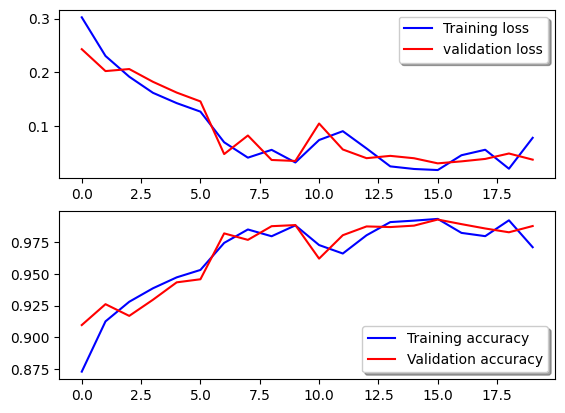

In [15]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['binary_accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_binary_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [31]:
y_true_all = []
y_pred_all = []

for images, labels in val_dataset:
    y_true_all.extend(labels.numpy())
    y_pred_all.extend((model.predict(images) > 0.5).astype(int).flatten())

conf_matrix = confusion_matrix(y_true_all, y_pred_all)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
4/4 ━━━━━━━━

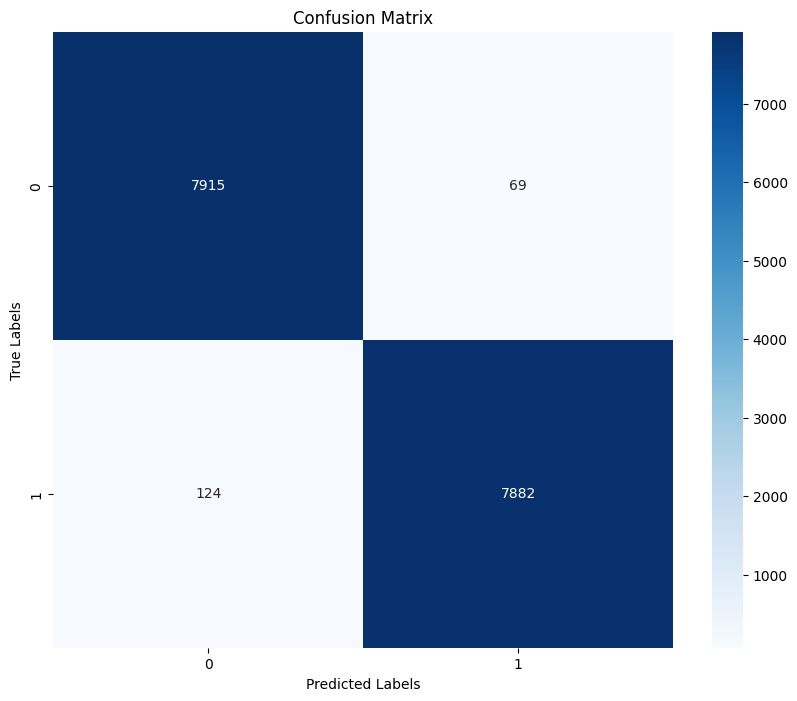

In [32]:
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [20]:
model.save("model.h5")

### Submission

In [34]:
test_df = pd.read_csv("/kaggle/input/ai-vs-human-generated-dataset/test.csv")
test_df

,id
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg
...,...
5535,test_data_v2/483412064ff74d9d9472d606b65976d9.jpg
5536,test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg
5537,test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg
5538,test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg


In [36]:
def load_test_image(file_path):
    img = tf.io.read_file("/kaggle/input/ai-vs-human-generated-dataset/" + file_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, size=(128, 128), method="bicubic")
    img = img / 255.0
    return img

In [37]:
test_paths = test_df["id"].values

In [38]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_paths)

test_dataset = test_dataset.map(load_test_image)

batch_size = 128
test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [39]:
y_pred_probs = model.predict(test_dataset)

y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

44/44 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step


In [58]:
test_df['label'] = y_pred_classes

test_df.to_csv("submission.csv", index=False)
test_df

,id,label
0,test_data_v2/1a2d9fd3e21b4266aea1f66b30aed157.jpg,0
1,test_data_v2/ab5df8f441fe4fbf9dc9c6baae699dc7.jpg,0
2,test_data_v2/eb364dd2dfe34feda0e52466b7ce7956.jpg,0
3,test_data_v2/f76c2580e9644d85a741a42c6f6b39c0.jpg,0
4,test_data_v2/a16495c578b7494683805484ca27cf9f.jpg,0
...,...,...
5535,test_data_v2/483412064ff74d9d9472d606b65976d9.jpg,0
5536,test_data_v2/c0b49ba4081a4197b422dac7c15aea7f.jpg,0
5537,test_data_v2/01454aaedec140c0a3ca1f48028c41cf.jpg,0
5538,test_data_v2/e9adfea8b67e4791968c4c2bdd8ec343.jpg,0
